In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import random
from skimage.feature import hog
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys
from scipy.ndimage.measurements import label
import math
%matplotlib inline

## Step 1: Load and examing data

In [2]:
# loading project dataset
# car images and none car images

# get vehicles and non-vehicles images from here
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
# and extract into data directory
cars = glob.glob('data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('data/non-vehicles/**/*.png', recursive=True)

# loading car images
image_car = []
for imgpath in cars:
#     image_car.append (mpimg.imread(imgpath))
      image_car.append (cv2.imread(imgpath))

# loading non car images
image_notcar = []
for imgpath in notcars:
    image_notcar.append (cv2.imread(imgpath))

car_count = len (image_car)
notcar_count = len (image_notcar)

print ('dataset has cars:', car_count)
print ('none cars:', notcar_count)

dataset has cars: 8792
none cars: 8968


Max value of the car image: 184 
Min value of the car image: 0 


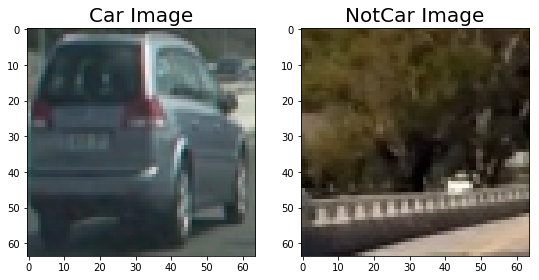

In [70]:
# display the image by randomly choose one from each catogery

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,9))
# f.tight_layout()
ax1.imshow(cv2.cvtColor(image_car[random.randint (0, car_count-1)], cv2.COLOR_BGR2RGB))

# ax1.imshow(image_car[3519])

# ax1.imshow(cv2.cvtColor(image_car[random.randint (0, car_count-1)], cv2.COLOR_BGR2RGB))
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(cv2.cvtColor(image_notcar[random.randint (0, notcar_count-1)], cv2.COLOR_BGR2RGB))

# ax2.imshow(cv2.cfvtColor(image_notcar[random.randint (0, notcar_count-1)], cv2.COLOR_BGR2RGB))
ax2.set_title('NotCar Image', fontsize=20)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


print ("Max value of the car image: %.f " % np.max(image_car[random.randint (0, car_count-1)]))
print ("Min value of the car image: %.f " % np.min(image_car[random.randint (0, car_count-1)]))

In [71]:
# f.savefig('./output_images/example.jpg')   # save the figure to file

Preliminary investigation shows that number of data for both categories are compatable and hence data balancing is not necessary.

## Step 2: Feature extraction

Helper functions for extracting different features

In [5]:
# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
        
    iteration : Current iteration (Int)
    total     : Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [6]:
# color histogram 
def color_hist(image, nbins = 32, bins_range = (0, 256)):
    """Calculate histograms of all channels of the image,
    concatenate and return it as feature vector
    Args:
        img (numpy.array): image
        nbins (int): number of histogram bins, 32 by default
        bins_range (tuple): range for bins values, default (0, 1)
    Returns:
        feature_vector(numpy.array)
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:,:,0], bins = nbins, range = bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins = nbins, range = bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins = nbins, range = bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

In [7]:
# spatial bin feature
def spatial_bin(image, size = (32, 32)):
    """Calculated spatial features
    Args:
        image (numpy.array): image
        size (tuple): resize img before calculating features
            default value is (32, 32)
    Returns:
        feature_vector(numpy.array)
    """
    # Use cv2.resize().ravel() to create the feature vector
    spatial_features = cv2.resize(image, size).ravel()
    
    return spatial_features

In [8]:
# hog feature extraction
def get_hog_features(image, orient, pix_per_cell, cell_per_block, vis = False, feature_vec = True):
    """Return HOG features and its visualization if needed
    Args:
        image (numpy.array): image for feature extraction
        orient (int): number of orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        vis (boolean): default False, return visualization image as second return parameter
        feature_vec (boolean): default True, return features as vector
    Returns:
        features or features, hog_image(image)
    """
    # output visualization as well if vis==True
    if vis == True:
        features, hog_image = hog(image, orientations = orient, pixels_per_cell = (pix_per_cell,pix_per_cell), 
                                  cells_per_block = (cell_per_block, cell_per_block),
                                  visualise = vis, feature_vector = feature_vec)
        return features, hog_image
    else:
        features = hog(image, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                       cells_per_block = (cell_per_block, cell_per_block),
                       visualise = vis, feature_vector = feature_vec)
        return features 

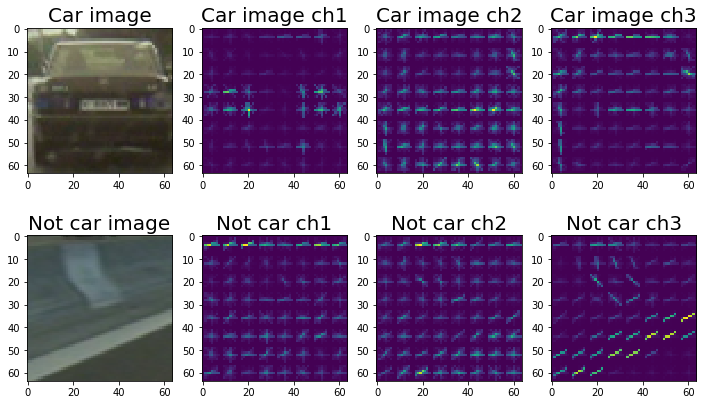

In [90]:
car = image_car[random.randint (0, car_count-1)]
not_car = image_notcar[random.randint (0, car_count-1)]

feature_image_car = cv2.cvtColor(car, getattr(cv2, 'COLOR_RGB2' + color_space))
feature_image_notcar = cv2.cvtColor(not_car, getattr(cv2, 'COLOR_RGB2' + color_space))

features, hog1_image_car = get_hog_features(feature_image_car[:,:,0], orient, pix_per_cell, cell_per_block, vis = True, feature_vec = True)
features, hog2_image_car = get_hog_features(feature_image_car[:,:,1], orient, pix_per_cell, cell_per_block, vis = True, feature_vec = True)
features, hog3_image_car = get_hog_features(feature_image_car[:,:,2], orient, pix_per_cell, cell_per_block, vis = True, feature_vec = True)

features, hog1_image_notcar = get_hog_features(feature_image_notcar[:,:,0], orient, pix_per_cell, cell_per_block, vis = True, feature_vec = True)
features, hog2_image_notcar = get_hog_features(feature_image_notcar[:,:,1], orient, pix_per_cell, cell_per_block, vis = True, feature_vec = True)
features, hog3_image_notcar = get_hog_features(feature_image_notcar[:,:,2], orient, pix_per_cell, cell_per_block, vis = True, feature_vec = True)

f, ((ax1, ax2, ax3, ax4), (ax5, ax6,ax7, ax8)) = plt.subplots(2, 4, figsize=(12,7))

plt.subplot(2,4,1)
plt.imshow(car)
plt.title('Car image',fontsize=20)

plt.subplot(2,4,2)
plt.imshow(hog1_image_car)
plt.title('Car image ch1',fontsize=20)

plt.subplot(2,4,3)
plt.imshow(hog2_image_car)
plt.title('Car image ch2',fontsize=20)

plt.subplot(2,4,4)
plt.imshow(hog3_image_car)
plt.title('Car image ch3',fontsize=20)

plt.subplot(2,4,5)
plt.imshow(not_car)
plt.title('Not car image',fontsize=20)

plt.subplot(2,4,6)
plt.imshow(hog1_image_notcar)
plt.title('Not car ch1',fontsize=20)

plt.subplot(2,4,7)
plt.imshow(hog2_image_notcar)
plt.title('Not car ch2',fontsize=20)

plt.subplot(2,4,8)
plt.imshow(hog3_image_notcar)
plt.title('Not car ch3',fontsize=20)



In [78]:
# f.savefig('./output_images/example_hog_feature.jpg')   # save the figure to file

In [9]:
def single_image_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    """Extract spatial, color and hog features from single image
    Args:
        image (numpy.array): image in BGR format from cv2.imread
        color_space: GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
        spatial_size (tuple): resize img before calculating spatial features, (32, 32) by default
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations, 9 by default
        pix_per_cell (int): number of pixels in HOG cell, 8 by default
        cell_per_block (int): number of HOG cells in block, 2 by default
        hog_channel (int): channel to use for HOG features calculating
        channels: 0, 1, 2, 'ALL'
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        features_vector (list(numpy.array)): list of feature vectors
    """
    #1) Define an empty list to receive features
    features = []
    #2) Apply color conversion if other than 'RGB'
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if color_space != 'RGB':
        feature_image = cv2.cvtColor(img, getattr(cv2, 'COLOR_RGB2' + color_space))
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = spatial_bin(feature_image, size=spatial_size)
        #4) Append features to list
        features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)     
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(features)

In [10]:
def extract_features(images, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):  
    """Extract spatial, color and hog features from list of images
    Args:
        image (numpy.array): image in BGR format from cv2.imread
        color_space: GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
        spatial_size (tuple): resize img before calculating spatial features, (32, 32) by default
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations, 9 by default
        pix_per_cell (int): number of pixels in HOG cell, 8 by default
        cell_per_block (int): number of HOG cells in block, 2 by default
        hog_channel (int): channel to use for HOG features calculating
        channels: 0, 1, 2, 'ALL'
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        features_vector (list(numpy.array)): list of feature vectors
    """                        
    features = []
#     print('Extracting feature...')
    for image in images:
#     for idx, image in enumerate(images):
        image_features = single_image_features(image, color_space= color_space, spatial_size= spatial_size,
                                                hist_bins = hist_bins, orient = orient, 
                                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel,spatial_feat=spatial_feat, 
                                                hist_feat=hist_feat, hog_feat=hog_feat)
        
        features.append(image_features)
       
    #       image_flip = cv2.flip(image,1)
        
#         image_features_flip = single_image_features(image_flip, color_space= color_space, spatial_size= spatial_size,
#                                                 hist_bins = hist_bins, orient = orient, 
#                                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                                                 hog_channel=hog_channel,spatial_feat=spatial_feat, 
#                                                 hist_feat=hist_feat, hog_feat=hog_feat)
#         features.append(image_features_flip)
#         print_progress(idx + 1, len(images) )

#     print('Feature extraction is completed') 
#     print("\n")

    return features

In [11]:
# parameters of feature extraction
color_space = 'HSV' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or 'ALL'
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [12]:
ft=time.time()

car_features = extract_features(image_car, color_space = color_space, 
                        spatial_size = spatial_size, hist_bins = hist_bins, 
                        orient = orient, pix_per_cell = pix_per_cell, 
                        cell_per_block = cell_per_block, 
                        hog_channel = hog_channel, spatial_feat = spatial_feat, 
                        hist_feat = hist_feat, hog_feat = hog_feat)

notcar_features = extract_features(image_notcar, color_space = color_space, 
                        spatial_size = spatial_size, hist_bins = hist_bins, 
                        orient = orient, pix_per_cell = pix_per_cell, 
                        cell_per_block = cell_per_block, 
                        hog_channel = hog_channel, spatial_feat = spatial_feat, 
                        hist_feat = hist_feat, hog_feat = hog_feat)
ft2=time.time()
print ('features extraction time: ', round(ft2-ft, 2))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


features extraction time:  77.19


In [13]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Car samples', len(car_features))
print('NotCar samples', len(notcar_features))
print('Training examples', len(X_train))
print('Testing examples', len(X_test))


Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7152
Car samples 8792
NotCar samples 8968
Training examples 14208
Testing examples 3552


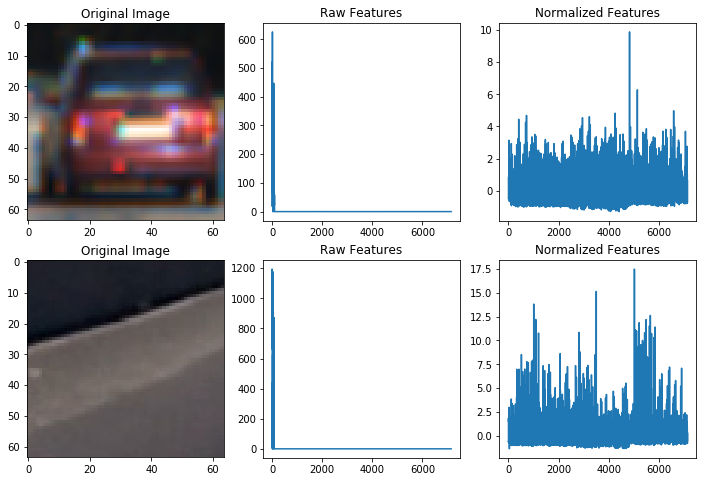

In [83]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(len(cars), len(cars)+len(notcars))  

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(cv2.cvtColor(cv2.imread(cars[car_ind]), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(232)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(233)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
# fig.tight_layout()
plt.subplot(234)
plt.imshow(mpimg.imread(notcars[notcar_ind - len(cars)]))
plt.title('Original Image')
plt.subplot(235)
plt.plot(X[notcar_ind])
plt.title('Raw Features')
plt.subplot(236)
plt.plot(scaled_X[notcar_ind])
plt.title('Normalized Features')
# fig.tight_layout()

# fig.savefig('./output_images/example_normalized_feature.jpg')   # save the figure to file

## Step 3: Model Training

In [15]:
# LinearSVC
from sklearn.svm import LinearSVC

# Use a SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

3.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9947


## Step 4: Vehicle detection

In [16]:
def draw_boxes(image, bboxes, color=(0, 0, 255), thick = 6):
    """Draws windows or bounding boxes on the image
    Args:
        image (numpy.array): image to search
        bboxes (list): bounding boxes
        color (tuple): bounding box color, default is (0, 0, 255)
        thick (int): thickness of bounding box, default is 6 pixels
    Returns:
        image copy with boxes drawn
    """
    # Make a copy of the image
    imcopy = np.copy(image)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [33]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def search_windows(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, 
                   cell_per_block, spatial_size, hist_bins, color_space, spatial_feat=True, 
                   hist_feat=True):
    """Apply specified classificator to specified windows
    and returns hot windows - windows classified as holding interesting object
    Args:
        image (numpy.array): image to search
        windows (list): list of coordinates of sliding windows in form of
            ((top left x, top left y), (bottom right x, bottom right y))
        spatial_size (tuple): resize img before calculating spatial features
            default value is (32, 32)
        hist_bins (int): number of histogram bins, 32 by default
        orient (int): number of HOG orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        hog_channel (int): channel to use for HOG features calculating, default 0
        spatial_feat (boolean): calculate spatial featues, default True
        hist_feat (boolean): calculate histogram featues, default True
        hog_feat (boolean): calculate HOG featues, default True
    Returns:
        list of hot windows
    """    
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_tosearch = image[ystart:ystop,xstart:xstop,:]
    feature_image = cv2.cvtColor(img_tosearch, getattr(cv2, 'COLOR_RGB2' + color_space))
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = feature_image.shape
        feature_image = cv2.resize(feature_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = feature_image[:,:,0]
    ch2 = feature_image[:,:,1]
    ch3 = feature_image[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(feature_image[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)
            
            if spatial_feat == True:
                spatial_features = spatial_bin(subimg, size=spatial_size)

            # Scale features and make a prediction
            if hist_feat == True and spatial_feat == True:
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            elif hist_feat == True:
                test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))  
            elif spatial_feat == True:
                test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1)) 
            else:
                test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1)) 

            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                hot_windows.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart)))
    
    return hot_windows
    
ystart = 380
ystop = 670
xstart = 600
xstop = 1400
scale = 1.5

In [34]:
def hot_boxes (image):
    """Applies sliding windows to images
    and finds hot windows. Also returns image with all hot boxes are drawn
    Args:
        image (numpy.array): image
    Returns:
        hot_windows(list), image_with_hot_windows_drawn(numpy.array)
    """

    imcopy = np.copy (image)
    all_hot_windows = []
                    
 
    hot_windows = search_windows(image, ystart, ystop, xstart, xstop,scale, svc, X_scaler, orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, color_space=color_space, 
                                 spatial_feat=spatial_feat, hist_feat=hist_feat)
        
    all_hot_windows.extend (hot_windows)

    imcopy = draw_boxes(imcopy, hot_windows, color=(0, 0, 255), thick=4)

    return all_hot_windows, imcopy

In [35]:
def heat_map(bbox_list, image):
    """Computes heat map of hot windows. Puts all specified
    hot windows on top of each other, so every pixel of returned image will
    contain how many hot windows covers this pixel
    Args:
        image (numpy.array): image
    Returns:
        heatmap (numpy.array): grayscale image of the same size as input image
    """

    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

In [36]:
def heat_threshold(heatmap, threshold = 1):
    """Computes thresholed heat map to avoid false positive
    Args:
        heatmap (numpy.array): grayscale image of the same size as input image
        threshold (int): minimum detected number of boxed windows 
    Returns:
        heatmap (numpy.array): grayscale image of the same size as input image
    """    
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

In [37]:
def draw_labeled_bboxes(image, heatmap):
    """Draw labeled box on the image
    Args:
        image (numpy.array): image
        heatmap (numpy.array): grayscale image of the same size as input image   
    Returns:
        image with box drawn around detected cars 
    """ 
    #Iterate through all detected cars
    # labels is a 2-tuple, the first item is an array the size of the heatmap and the second element
    # is the number of labels(cars) found
    
    labels = label(heatmap)
    imcopy = np.copy(image)
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of the pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define bounding box based on min/max of nonzeroy/x
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),(np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
        
    return imcopy

#### Alternative algorithm for hotbox smoothing

Main idea: assign weights to heatmap according to the percentage area of overlapping

In [38]:
def percent_overlap(box1, box2):
    
    x11 = box1 [0][0]
    y11 = box1 [0][1]
    x12 = box1 [1][0]
    y12 = box1 [1][1]
    x21 = box2 [0][0]
    y21 = box2 [0][1]
    x22 = box2 [1][0]
    y22 = box2 [1][1]
            
    x_overlap = max(0, min(x12,x22) - max(x11,x21))
    y_overlap = max(0, min(y12,y22) - max(y11,y21))

    area1 = (x12 - x11) * (y12 - y11)
    area2 = (x22 - x21) * (y22 - y21)
    intersection = x_overlap * y_overlap;
    
    percent_box1,  percent_box2= intersection*1.0/area1, intersection*1.0/area2
   
    return percent_box1,  percent_box2

In [39]:
def is_overlap (box1, box2): 
    is_overlap = False
    
    x11 = box1 [0][0]
    y11 = box1 [0][1]
    x12 = box1 [1][0]
    y12 = box1 [1][1]
    x21 = box2 [0][0]
    y21 = box2 [0][1]
    x22 = box2 [1][0]
    y22 = box2 [1][1]
            
    x_overlap = max(0, min(x12,x22) - max(x11,x21))
    y_overlap = max(0, min(y12,y22) - max(y11,y21))
    
    if x_overlap != 0 and y_overlap != 0:
        is_overlap =  True

    return is_overlap    

In [40]:
def calc_heat_maps (hotboxes, image):
    """Compute average boxes from specified hot boxes and returns
    average boxes with equals or higher strength
    """
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
     # Iterate through list of bboxes
    for box in hotboxes:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    for idx in range(len(hotboxes)):
        box1 = hotboxes[idx]
        for idy in range(idx):
            box2 = hotboxes[idy]
            if is_overlap(box1, box2):
                percent_box1,  percent_box2 = percent_overlap(box1, box2)
                if percent_box1 <= 0.3 and percent_box2 <= 0.3:
                    percent = np.max((percent_box1,percent_box2))
                    heatmap[box1[0][1]:box1[1][1], box1[0][0]:box1[1][0]] += percent
                    heatmap[box2[0][1]:box2[1][1], box2[0][0]:box2[1][0]] += percent
                elif percent_box1 > 0.3:
                    heatmap[box1[0][1]:box1[1][1], box1[0][0]:box1[1][0]] += percent_box1
                elif percent_box2 > 0.3:
                    heatmap[box2[0][1]:box2[1][1], box2[0][0]:box2[1][0]] += percent_box2
    
    return heatmap

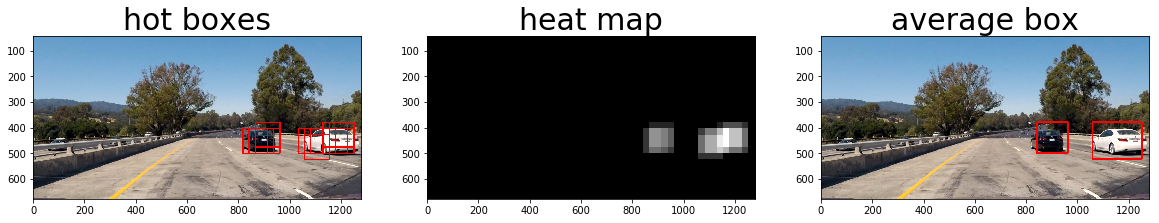

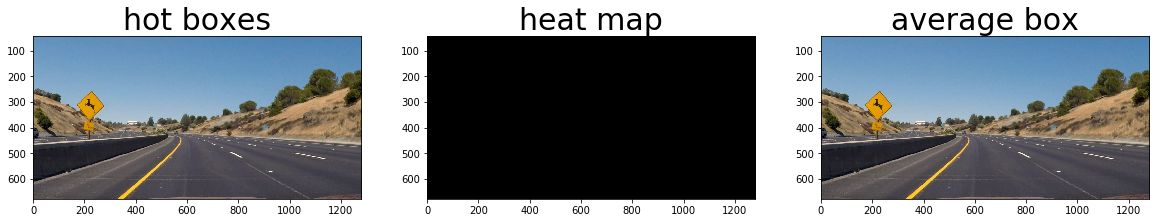

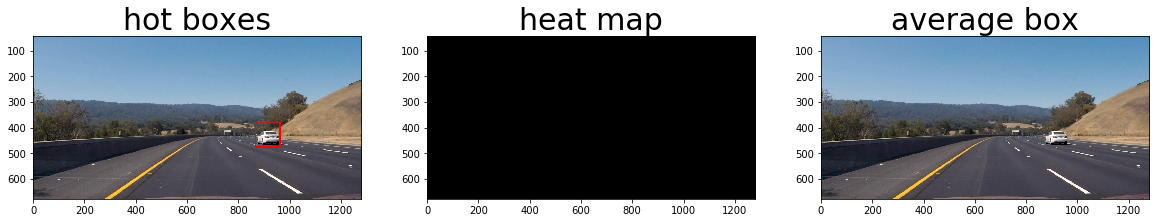

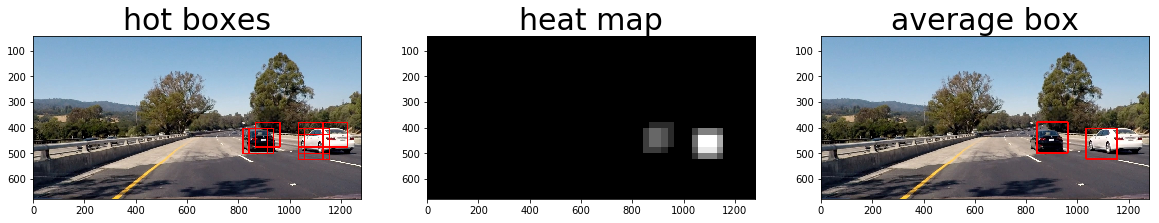

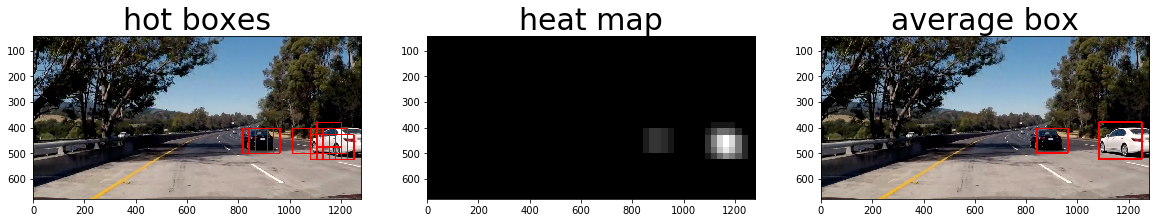

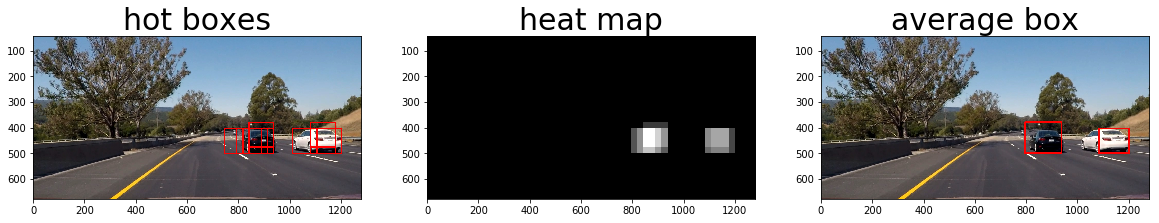

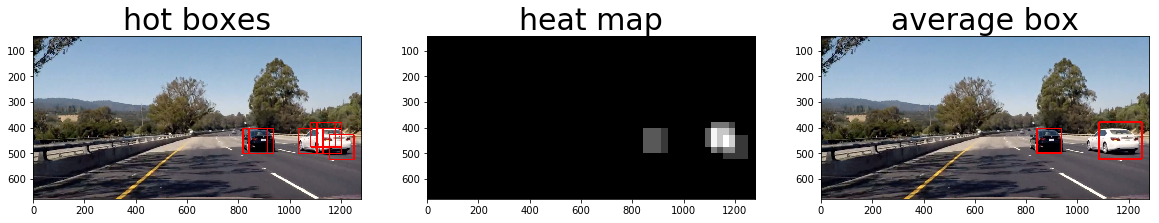

In [88]:
# algorithm taking advantage of heatmap
for impath in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(impath)
    
    # hot boxes
    hotboxes, image_with_hot_boxes = hot_boxes (image)
    # heat map
    heatmap = calc_heat_maps (hotboxes, image)
#     heatmap = heat_map (hotboxes, image)

    heat_binary = heat_threshold(heatmap, threshold = 1.5)
    average = draw_labeled_bboxes(image, heat_binary)
    
    f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey='col', sharex='row', figsize=(20,3))
#     f.tight_layout()
        
    ax1.set_title('hot boxes', fontsize=30)
    ax1.imshow(cv2.cvtColor(image_with_hot_boxes, cv2.COLOR_BGR2RGB))
    ax2.set_title('heat map', fontsize=30)
    ax2.imshow(heatmap, cmap = 'gray')    
    ax3.set_title('average box', fontsize=30)
    ax3.imshow(cv2.cvtColor(average, cv2.COLOR_BGR2RGB))
#     f.savefig('./output_images/example_boxes.jpg')   # save the figure to file 

## Step 5: Video pipeline

In [43]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
# pipeline for ane detection
# Buffer for retaining host_boxes information between frames

hot_boxes_hist = None

def process_frame(image):
    
    global hot_boxes_hist
    # of frames to average
    N = 10  
    # hot boxes
    hotboxes, image_with_hot_boxes = hot_boxes(image)

    if hot_boxes_hist is None or len(hot_boxes_hist) == 0:
        hot_boxes_hist = []
        hot_boxes_hist.append(hotboxes)
        heatmap = calc_heat_maps (hotboxes, image)
        heat_binary = heat_threshold(heatmap, threshold = 1.5)
   
    else:
        
        if len(hot_boxes_hist) > N:
            hot_boxes_hist = hot_boxes_hist[1:]
            
        hot_boxes_hist.append(hotboxes)
        
        all_box = []
        
        for box in hot_boxes_hist:
            all_box.extend(box)
            
        heatmap = calc_heat_maps (all_box, image)
        heat_binary = heat_threshold(heatmap, threshold = 20)   
        
    average = draw_labeled_bboxes(image, heat_binary) 
 
    return average

In [91]:
white_output = 'test_videos_output/test_video.mp4'
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

CPU times: user 10.5 s, sys: 346 ms, total: 10.9 s
Wall time: 11.3 s


In [46]:
white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [04:50<00:00,  5.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 4min 48s, sys: 9.9 s, total: 4min 58s
Wall time: 4min 50s
